In [1]:
!pip -q install shap==0.46.0 lime==0.2.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.2/540.2 kB 10.0 MB/s eta 0:00:00a 0:00:01


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# ======================
# Cell 1 - imports 
# ======================
import warnings, random, os, re
from pathlib import Path
warnings.filterwarnings("ignore", message="is_sparse is deprecated", category=DeprecationWarning)

# 1) Use Kaggle's preinstalled RL libs (avoid pinning/installs here)
import gymnasium as gym
import stable_baselines3 as sb3
print("[using]", "gymnasium", gym.__version__, "| stable-baselines3", sb3.__version__)
# Expected on Kaggle: gymnasium 0.29.0, stable-baselines3 2.1.0

# 2) Only install extra explainability libs (requires Internet = ON)
import sys, subprocess
def ensure(pkg):
    try:
        __import__(pkg)
        print(f"[ok] {pkg} already available")
    except Exception:
        print(f"[install] {pkg}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

ensure("shap")        # 0.46.0 is fine
ensure("lime")        # 0.2.0.1 is fine

# 3) Usual data science stack
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import datetime as dt

# 4) Reproducibility & paths
SEED = 42
random.seed(SEED); np.random.seed(SEED)

KAGGLE_INPUT = Path("/kaggle/input")
WORKDIR = Path("/kaggle/working")
WORKDIR.mkdir(exist_ok=True, parents=True)

# Dataset discovery (works with your layout)
def find_diabetes_data_root():
    for root, dirs, files in os.walk(KAGGLE_INPUT):
        for d in dirs:
            if d.lower() == "diabetes-data":
                return Path(root) / d
    local_folder = Path("./diabetes-data")
    return local_folder if local_folder.exists() else None

DATASET_ROOT = find_diabetes_data_root()
print("Detected dataset root:", DATASET_ROOT)

OUT_PROCESSED = WORKDIR / "processed"
OUT_REPORTS   = WORKDIR / "reports"
OUT_PROCESSED.mkdir(parents=True, exist_ok=True)
OUT_REPORTS.mkdir(parents=True, exist_ok=True)


2025-08-28 20:42:14.938991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756413735.282827      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756413735.379588      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[using] gymnasium 0.29.0 | stable-baselines3 2.1.0


/usr/local/lib/python3.11/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):


[ok] shap already available
[ok] lime already available
Detected dataset root: /kaggle/input/dataset/diabetes-data


In [ ]:
# ======================
# Cell 2  Parse raw event files
# ======================
assert DATASET_ROOT is not None, "Couldn't find the Diabetes-Data folder. Add it as a Kaggle dataset or upload the zip."

# Force into the inner 'Diabetes-Data' if present
inner = DATASET_ROOT
if (inner / "Diabetes-Data").exists():
    inner = inner / "Diabetes-Data"
elif inner.name.lower() != "diabetes-data":
    # last-resort search
    found = list(DATASET_ROOT.rglob("Diabetes-Data"))
    if len(found):
        inner = found[0]

print("Using data folder:", inner)

# (Optional) show a quick listing to verify files are visible
print("Top-level entries:", [p.name for p in list(inner.iterdir())[:12]])

# Optional: read Data-Codes for mappings
code_map = {}
dc = inner / "Data-Codes"
if dc.exists():
    txt = dc.read_text(errors="ignore")
    for ln in txt.splitlines():
        m = re.match(r"\s*(\d+)\s*=\s*(.*)", ln)
        if m:
            code_map[int(m.group(1))] = m.group(2).strip()

# Patient files (e.g., data-01, data-02, ...)
patient_files = sorted([p for p in inner.iterdir() if p.is_file() and re.fullmatch(r"data-\d+", p.name)])
print(f"Found {len(patient_files)} patient files:", [p.name for p in patient_files[:10]], "...")

def parse_patient_file(fp: Path):
    # Each line: date  time  code  value
    df = pd.read_csv(fp, sep=r"\s+", header=None, names=["date","time","code","value"], engine="python")
    df["code"] = pd.to_numeric(df["code"], errors="coerce").astype("Int64")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df["timestamp"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce")
    df = df.dropna(subset=["timestamp", "code"])
    df["code"] = df["code"].astype(int)
    df["patient_id"] = int(re.findall(r"\d+", fp.name)[0])  # e.g., data-01 -> 01
    return df[["patient_id","timestamp","code","value"]].sort_values("timestamp")

events = []
for fp in patient_files:
    try:
        events.append(parse_patient_file(fp))
    except Exception as e:
        print("Failed parsing", fp, "->", e)

if len(events) == 0:
    raise RuntimeError("No patient files parsed. Check the folder listing printed above.")

events_df = pd.concat(events, ignore_index=True).sort_values(["patient_id","timestamp"])
print("Raw events shape:", events_df.shape)
print(events_df.head(8))

# Convenience code groups
GLU_CODES = {48,57,58,59,60,61,62,63,64}   # glucose measurements
INS_CODES = {33,34,35}                     # insulin doses
MEAL_CODES = {66,67,68}                    # meals (typical/more/less)
EXER_CODES = {69,70,71}                    # exercise (typical/more/less)
HYPO_SYMPT = {65}                          # hypoglycemic symptoms


Using data folder: /kaggle/input/dataset/diabetes-data/Diabetes-Data
Top-level entries: ['data-10', 'data-39', 'data-46', 'data-28', 'data-37', 'data-68', 'data-52', 'data-34', 'data-58', 'data-57', 'data-03', 'data-04']
Found 70 patient files: ['data-01', 'data-02', 'data-03', 'data-04', 'data-05', 'data-06', 'data-07', 'data-08', 'data-09', 'data-10'] ...
Raw events shape: (29285, 4)
   patient_id           timestamp  code  value
0           1 1991-04-21 09:09:00    58  100.0
1           1 1991-04-21 09:09:00    33    9.0
2           1 1991-04-21 09:09:00    34   13.0
3           1 1991-04-21 17:08:00    62  119.0
4           1 1991-04-21 17:08:00    33    7.0
5           1 1991-04-21 22:51:00    48  123.0
6           1 1991-04-22 07:35:00    58  216.0
7           1 1991-04-22 07:35:00    33   10.0


In [6]:
# ======================
# Cell 3: Hourly panel per patient (+ glucose_next, robust resampling)
# ======================
import numpy as np, pandas as pd
from pathlib import Path

def build_hourly_panel(events_df, freq="1H"):
    dfs = []
    for pid, g in events_df.groupby("patient_id", sort=False):
        # ensure proper types
        g = g.copy()
        g["timestamp"] = pd.to_datetime(g["timestamp"], errors="coerce")
        g = g.dropna(subset=["timestamp"]).sort_values("timestamp")

        if g["timestamp"].empty:
            continue

        tmin, tmax = g["timestamp"].min(), g["timestamp"].max()
        if pd.isna(tmin) or pd.isna(tmax):
            continue

        # Base hourly index for this patient
        idx = pd.date_range(tmin.floor(freq), tmax.ceil(freq), freq=freq)
        base = pd.DataFrame({"patient_id": pid, "timestamp": idx})

        # ---- Glucose: carry last measurement backward to fill current hour ----
        glu = (
            g[g["code"].isin(GLU_CODES)][["timestamp","value"]]
            .rename(columns={"value":"glucose"})
            .dropna()
            .sort_values("timestamp")
        )
        if not glu.empty:
            # align to hourly with backward merge (last known value)
            glu_hourly = pd.merge_asof(
                base[["timestamp"]].sort_values("timestamp"),
                glu.sort_values("timestamp"),
                on="timestamp",
                direction="backward"
            )
        else:
            glu_hourly = base[["timestamp"]].copy()
            glu_hourly["glucose"] = np.nan

        # ---- Insulin per hour (regular/NPH/ultralente) via resample ----
        ins = g[g["code"].isin(INS_CODES)].copy()
        if not ins.empty:
            ins["ins_reg"]   = np.where(ins["code"]==33, ins["value"], 0.0)
            ins["ins_nph"]   = np.where(ins["code"]==34, ins["value"], 0.0)
            ins["ins_ultra"] = np.where(ins["code"]==35, ins["value"], 0.0)
            ins_hour = (
                ins.set_index("timestamp")
                   .resample(freq)
                   .agg({"ins_reg":"sum","ins_nph":"sum","ins_ultra":"sum"})
                   .reset_index()
                   .rename(columns={"index":"timestamp"})
            )
            base = base.merge(ins_hour, on="timestamp", how="left")
        else:
            base[["ins_reg","ins_nph","ins_ultra"]] = 0.0

        # ---- Meal intensity per hour (typical=1.0, more=1.5, less=0.5) ----
        meal = g[g["code"].isin(MEAL_CODES)].copy()
        if not meal.empty:
            size_map = {66:1.0, 67:1.5, 68:0.5}
            meal["meal_size"] = meal["code"].map(size_map).fillna(0.0)
            meal_hour = (
                meal.set_index("timestamp")
                    .resample(freq)["meal_size"].max()
                    .fillna(0.0)
                    .reset_index()
            )
            base = base.merge(meal_hour, on="timestamp", how="left")
        else:
            base["meal_size"] = 0.0

        # ---- Exercise intensity per hour (typical=1.0, more=1.5, less=0.5) ----
        ex = g[g["code"].isin(EXER_CODES)].copy()
        if not ex.empty:
            ex_map = {69:1.0, 70:1.5, 71:0.5}
            ex["ex_intensity"] = ex["code"].map(ex_map).fillna(0.0)
            ex_hour = (
                ex.set_index("timestamp")
                  .resample(freq)["ex_intensity"].max()
                  .fillna(0.0)
                  .reset_index()
            )
            base = base.merge(ex_hour, on="timestamp", how="left")
        else:
            base["ex_intensity"] = 0.0

        # ---- Merge glucose & clean ----
        base = base.merge(glu_hourly[["timestamp","glucose"]], on="timestamp", how="left")
        for col in ["ins_reg","ins_nph","ins_ultra","meal_size","ex_intensity"]:
            if col not in base:
                base[col] = 0.0
            base[col] = base[col].fillna(0.0)

        # Fill glucose then time-of-day features
        base["glucose"] = base["glucose"].ffill().bfill()
        hod = base["timestamp"].dt.hour + base["timestamp"].dt.minute/60.0
        base["tod_sin"] = np.sin(2*np.pi*hod/24)
        base["tod_cos"] = np.cos(2*np.pi*hod/24)

        # Minimal coverage guard
        if base["glucose"].notna().sum() < 5:
            continue

        dfs.append(base)

    # Combine patients
    if not dfs:
        return pd.DataFrame(columns=[
            "patient_id","timestamp","glucose","ins_reg","ins_nph","ins_ultra",
            "meal_size","ex_intensity","tod_sin","tod_cos","glucose_next"
        ])

    panel = (
        pd.concat(dfs, ignore_index=True)
        .sort_values(["patient_id","timestamp"])
        .reset_index(drop=True)
    )

    # Physiological clipping
    panel["glucose"] = panel["glucose"].clip(lower=30, upper=600)

    # --- One-step-ahead glucose target per patient ---
    panel["glucose_next"] = panel.groupby("patient_id")["glucose"].shift(-1)

    # Drop rows where target is missing (last hour of each patient)
    panel = panel.dropna(subset=["glucose","glucose_next"]).reset_index(drop=True)

    return panel

# Build & save panel
hourly_df = build_hourly_panel(events_df, freq="1H")
print("Hourly panel shape:", hourly_df.shape)
print(hourly_df.head(10))

summary = hourly_df.groupby("patient_id", as_index=False).agg(
    hours=("timestamp","count"),
    first=("timestamp","min"),
    last=("timestamp","max"),
    mean_glucose=("glucose","mean")
)
print("Patients:", summary.shape[0], "   Median hours per patient:", summary["hours"].median())

OUT_PROCESSED = Path("/kaggle/working/processed"); OUT_PROCESSED.mkdir(exist_ok=True, parents=True)
hourly_path = OUT_PROCESSED / "hourly_panel.parquet"
hourly_df.to_parquet(hourly_path, index=False)
print("Saved hourly panel to:", hourly_path)
print("Has glucose_next:", "glucose_next" in hourly_df.columns, "; non-null:", hourly_df["glucose_next"].notna().sum())


Hourly panel shape: (105351, 11)
   patient_id           timestamp  ins_reg  ins_nph  ins_ultra  meal_size  \
0           1 1991-04-21 09:00:00      9.0     13.0        0.0        0.0   
1           1 1991-04-21 10:00:00      0.0      0.0        0.0        0.0   
2           1 1991-04-21 11:00:00      0.0      0.0        0.0        0.0   
3           1 1991-04-21 12:00:00      0.0      0.0        0.0        0.0   
4           1 1991-04-21 13:00:00      0.0      0.0        0.0        0.0   
5           1 1991-04-21 14:00:00      0.0      0.0        0.0        0.0   
6           1 1991-04-21 15:00:00      0.0      0.0        0.0        0.0   
7           1 1991-04-21 16:00:00      0.0      0.0        0.0        0.0   
8           1 1991-04-21 17:00:00      7.0      0.0        0.0        0.0   
9           1 1991-04-21 18:00:00      0.0      0.0        0.0        0.0   

   ex_intensity  glucose       tod_sin       tod_cos  glucose_next  
0           0.0    100.0  7.071068e-01 -7.071068e-

In [ ]:
# ======================
# Cell 4: Patient-wise split & scaler 
# ======================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np, json

SEED = 42

# keep only patients with enough coverage
patient_hours = hourly_df.groupby("patient_id")["timestamp"].count()
keep_ids = patient_hours[patient_hours >= 48].index.tolist()
data_df = hourly_df[hourly_df["patient_id"].isin(keep_ids)].copy()

# patient-wise split
train_ids, temp_ids = train_test_split(keep_ids, test_size=0.4, random_state=SEED)
val_ids, test_ids   = train_test_split(temp_ids, test_size=0.5, random_state=SEED)

splits = {"train": sorted(train_ids), "val": sorted(val_ids), "test": sorted(test_ids)}
print("Split sizes: train/val/test =", len(train_ids), len(val_ids), len(test_ids))
print({k: ids[:10] for k,ids in splits.items()})

splits_path = OUT_PROCESSED / "splits.json"
with open(splits_path, "w") as f:
    json.dump(splits, f, indent=2)
print("Saved splits to:", splits_path)

# features for scaler (X) — target is glucose_next
FEATURES = ["glucose","ins_reg","ins_nph","ins_ultra","meal_size","ex_intensity","tod_sin","tod_cos"]
train_mask = data_df["patient_id"].isin(train_ids)

# fit scaler on TRAIN only (no leakage), transform all splits
scaler = StandardScaler().fit(data_df.loc[train_mask, FEATURES])
data_df_scaled = data_df.copy()
data_df_scaled[FEATURES] = scaler.transform(data_df_scaled[FEATURES])

print("Scaled feature means (train ~0):",
      np.round(data_df_scaled.loc[train_mask, FEATURES].mean(), 3).to_dict())
print("Scaled feature stds  (train ~1):",
      np.round(data_df_scaled.loc[train_mask, FEATURES].std(), 3).to_dict())

# persist scaled panel
scaled_path = OUT_PROCESSED / "hourly_panel_scaled.parquet"
data_df_scaled.to_parquet(scaled_path, index=False)
print("Saved scaled hourly panel to:", scaled_path)

# ---------- build split DataFrames and enforce dtypes ----------
df_by_split = {
    "train": data_df_scaled[data_df_scaled["patient_id"].isin(train_ids)].copy(),
    "val":   data_df_scaled[data_df_scaled["patient_id"].isin(val_ids)].copy(),
    "test":  data_df_scaled[data_df_scaled["patient_id"].isin(test_ids)].copy(),
}

# ensure target present and remove any trailing NaNs (last hour per patient)
for k in ("train","val","test"):
    if "glucose_next" not in df_by_split[k].columns:
        raise KeyError("glucose_next not found; ensure Cell 3 created it.")
    df_by_split[k] = df_by_split[k].dropna(subset=["glucose","glucose_next"])

# ML-friendly dtypes
for k in ("train","val","test"):
    df_by_split[k][FEATURES] = df_by_split[k][FEATURES].astype("float32")
    df_by_split[k]["glucose_next"] = df_by_split[k]["glucose_next"].astype("float32")

# shortcuts used downstream
train_df = df_by_split["train"]
val_df   = df_by_split["val"]
test_df  = df_by_split["test"]

print("Split frames built:", {k: df_by_split[k].shape for k in df_by_split})


Split sizes: train/val/test = 42 14 14
{'train': [2, 3, 4, 7, 9, 12, 14, 15, 16, 18], 'val': [5, 8, 11, 17, 29, 32, 34, 41, 45, 48], 'test': [1, 6, 10, 13, 19, 23, 31, 35, 36, 43]}
Saved splits to: /kaggle/working/processed/splits.json
Scaled feature means (train ~0): {'glucose': 0.0, 'ins_reg': 0.0, 'ins_nph': -0.0, 'ins_ultra': 0.0, 'meal_size': -0.0, 'ex_intensity': 0.0, 'tod_sin': 0.0, 'tod_cos': -0.0}
Scaled feature stds  (train ~1): {'glucose': 1.0, 'ins_reg': 1.0, 'ins_nph': 1.0, 'ins_ultra': 1.0, 'meal_size': 1.0, 'ex_intensity': 1.0, 'tod_sin': 1.0, 'tod_cos': 1.0}
Saved scaled hourly panel to: /kaggle/working/processed/hourly_panel_scaled.parquet
Split frames built: {'train': (63379, 11), 'val': (16527, 11), 'test': (25445, 11)}


/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):


In [ ]:
# ======================
# Cell 5 — Split & features sanity checks 
# ======================
assert all(k in df_by_split for k in ("train","val","test"))
print({k: df_by_split[k].shape for k in df_by_split})

# FEATURES presence
missing = [c for c in FEATURES if c not in df_by_split["train"].columns]
assert not missing, f"Missing features: {missing}"

# glucose_next check (needed later for dynamics)
if "glucose_next" not in df_by_split["train"].columns:
    # If absent, build it once in your panel cell (recommended spot: end of Cell 3)
    print("WARNING: 'glucose_next' not found. Add it in Cell 3 as a per-patient shift.")
else:
    # Make sure no NaNs in target
    for k in df_by_split:
        df_by_split[k] = df_by_split[k].dropna(subset=["glucose","glucose_next"])
        # keep the shortcuts in sync
    train_df = df_by_split["train"]; val_df = df_by_split["val"]; test_df = df_by_split["test"]
    print("NaN rows dropped where needed; shapes:", {k: v.shape for k,v in df_by_split.items()})


{'train': (63379, 11), 'val': (16527, 11), 'test': (25445, 11)}
NaN rows dropped where needed; shapes: {'train': (63379, 11), 'val': (16527, 11), 'test': (25445, 11)}


In [9]:
# ======================
# Cell 6: Gym Environment
# ======================
import gymnasium as gym
from gymnasium import spaces

class DiabetesEnv(gym.Env):
    """
    A simple RL environment that simulates diabetes management
    using real patient hourly data.
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, df, splits, split="train", features=None, horizon=72):
        super(DiabetesEnv, self).__init__()
        self.df = df
        self.splits = splits
        self.split = split
        self.features = features or ["glucose","ins_reg","ins_nph","ins_ultra","meal_size","ex_intensity","tod_sin","tod_cos"]
        self.horizon = horizon  # episode length in hours

        # Action space = insulin adjustment (units of regular insulin per hour)
        self.action_space = spaces.Box(low=0.0, high=20.0, shape=(1,), dtype=np.float32)

        # Observation space = scaled feature vector
        obs_dim = len(self.features)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        self.current_step = 0
        self.current_pid = None
        self.patient_df = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Pick a random patient from the split
        self.current_pid = np.random.choice(self.splits[self.split])
        patient_data = self.df[self.df["patient_id"] == self.current_pid].sort_values("timestamp")
        self.patient_df = patient_data.reset_index(drop=True)

        # Pick a random start point
        start = np.random.randint(0, len(self.patient_df) - self.horizon)
        self.current_step = start

        obs = self.patient_df.loc[self.current_step, self.features].to_numpy(dtype=np.float32)
        return obs, {}

    def step(self, action):
        insulin_dose = float(action[0])

        # Move forward in time
        self.current_step += 1
        done = self.current_step >= len(self.patient_df) - 1

        obs = self.patient_df.loc[self.current_step, self.features].to_numpy(dtype=np.float32)
        glucose = float(self.patient_df.loc[self.current_step, "glucose"])

        # Reward: closer to [90, 130] mg/dL is better
        if 90 <= glucose <= 130:
            reward = 1.0
        else:
            reward = -abs(glucose - 110) / 50.0  # penalize deviation

        # Small penalty for large insulin doses
        reward -= 0.01 * insulin_dose

        return obs, reward, done, False, {}

    def render(self, mode="human"):
        g = float(self.patient_df.loc[self.current_step, "glucose"])
        print(f"Step={self.current_step}, Glucose={g:.1f}")

# Quick test
env = DiabetesEnv(data_df_scaled, splits, split="train")
obs, _ = env.reset()
print("Initial observation:", obs)
obs, reward, done, _, _ = env.step([5.0])
print("Next obs:", obs, " Reward:", reward)


Initial observation: [ 1.8574682e+00  4.3991733e+00 -1.3394390e-01 -9.1218844e-02
  1.0428755e+01 -4.6917133e-02 -1.4144340e+00  1.4928891e-03]
Next obs: [-1.0323102  -0.23105125 -0.1339439  -0.09121884 -0.07248922 -0.04691713
 -1.3662504   0.36755365]  Reward: -2.2706462055916767


In [10]:
# ======================
# Cell 7: PPO Training
# ======================
from stable_baselines3 import PPO

# Wrap env into a function so PPO can create multiple copies
def make_env(split="train"):
    return DiabetesEnv(data_df_scaled, splits, split=split)

train_env = make_env("train")

# Define PPO model
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=256,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    seed=SEED
)

# Train for a small number of timesteps first (just to test)
model.learn(total_timesteps=10_000)

# Save the model
model.save(str(OUT_PROCESSED / "ppo_diabetes"))
print("PPO model trained and saved.")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 123      |
|    ep_rew_mean     | -271     |
| time/              |          |
|    fps             | 270      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 256      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 123           |
|    ep_rew_mean          | -271          |
| time/                   |               |
|    fps                  | 224           |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00028206734 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2      

In [11]:
# ======================
# Cell 8 — Train glucose dynamics model (robust to missing val_df)
# ======================
import numpy as np
import pandas as pd

# Required from earlier cells:
# - FEATURES: list of feature columns (same order used to fit the scaler)
# - scaler: StandardScaler fitted on TRAIN FEATURES
# - Either (train_df, val_df) already exist, OR df_by_split dict exists with 'train'/'val'/'valid'/'test'
# - train_df/val_df must contain 'glucose' and 'glucose_next'

# ---- get train_df / val_df robustly ----
def _get_split_df():
    # Try existing variables first
    td = globals().get("train_df", None)
    vd = globals().get("val_df", None)

    # If not present, try df_by_split
    dbs = globals().get("df_by_split", {})
    if td is None and isinstance(dbs, dict) and "train" in dbs:
        td = dbs["train"].copy()
    if vd is None and isinstance(dbs, dict):
        for key in ("val", "valid", "test"):
            if key in dbs:
                vd = dbs[key].copy()
                break

    # If still no val, carve out a small slice from train
    if td is not None and vd is None:
        vd = td.sample(frac=0.1, random_state=42) if len(td) > 50 else td.iloc[: max(1, len(td)//10)]

    return td, vd

train_df, val_df = _get_split_df()
assert train_df is not None and len(train_df) > 0, "train_df not found or empty."
assert val_df is not None and len(val_df) > 0, "val_df not found; provide a val/valid/test split or keep a small slice from train."

# ---- sanity checks ----
glucose_col = "glucose"           # change if different
next_col    = "glucose_next"      # change if different
assert glucose_col in train_df.columns and next_col in train_df.columns, f"'{glucose_col}'/'{next_col}' must be in train_df."
assert glucose_col in val_df.columns and next_col in val_df.columns, f"'{glucose_col}'/'{next_col}' must be in val_df."
assert isinstance(FEATURES, (list, tuple)) and len(FEATURES) > 0, "FEATURES must be a non-empty list in the same order used to fit scaler."

# ---- FIX: index scaler arrays by FEATURES order, not full dataframe columns ----
assert glucose_col in FEATURES, f"{glucose_col} must be in FEATURES (got {FEATURES})"
g_idx   = FEATURES.index(glucose_col)
scale_g = float(scaler.scale_[g_idx])   # mg/dL per 1 standardized unit

# Inputs (X) come from standardized FEATURES
X_train = scaler.transform(train_df[list(FEATURES)].values).astype("float32")
X_val   = scaler.transform(val_df[list(FEATURES)].values).astype("float32")

# Target: Δglucose scaled consistently with the scaler used for FEATURES
y_train = ((train_df[next_col].values - train_df[glucose_col].values) * scale_g).astype("float32")
y_val   = ((val_df[next_col].values   - val_df[glucose_col].values)   * scale_g).astype("float32")

print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "| y_val:  ", y_val.shape)
print("scale_g (FEATURES order):", scale_g)

# ----- Your existing model definition & training loop here -----
# Example:
# model = DynNet(input_dim=X_train.shape[1], hidden=[128,128], out_dim=1)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train_dynamics(model, optimizer, X_train, y_train, X_val, y_val, epochs=10, batch_size=256)

# Save artifacts (as you already do)
# torch.save(model.state_dict(), OUT_PROCESSED / "dyn_model.pt")
# with open(OUT_PROCESSED / "dyn_meta.json", "w") as f: json.dump({"scale_g": scale_g}, f)


# ---- Train a quick MLP on Δglucose (standardized), then save ----
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json, joblib

# Recompute Δ and standardize on TRAIN ONLY (more stable than using feature scaler)
ytr_raw = (train_df["glucose_next"].values.astype("float32") - train_df["glucose"].values.astype("float32"))
yva_raw = (val_df["glucose_next"].values.astype("float32")   - val_df["glucose"].values.astype("float32"))
y_mean = float(ytr_raw.mean())
y_std  = float(ytr_raw.std() + 1e-8)

ytr = (ytr_raw - y_mean) / y_std
yva = (yva_raw - y_mean) / y_std

mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=512,
    learning_rate_init=1e-3,
    max_iter=50,              # keep quick; can raise if time permits
    early_stopping=True,
    validation_fraction=0.1,
    random_state=SEED,
    verbose=False
)
mlp.fit(X_train, ytr)

def _eval(df, X, y_raw, split):
    yhat_std = mlp.predict(X)
    yhat_raw = yhat_std * y_std + y_mean
    g_now  = df["glucose"].values.astype("float32")
    g_next = df["glucose_next"].values.astype("float32")
    g_pred = g_now + yhat_raw
    mae  = mean_absolute_error(g_next, g_pred)
    rmse = mean_squared_error(g_next, g_pred, squared=False)
    r2   = r2_score(g_next, g_pred)
    print(f"[{split}] next-glucose  MAE={mae:.2f}  RMSE={rmse:.2f}  R2={r2:.3f}")
    return mae, rmse, r2

_ = _eval(train_df, X_train, ytr_raw, "train")
_ = _eval(val_df,   X_val,   yva_raw, "val")

# Save artifacts for simulator (Cell 8)
joblib.dump(mlp, OUT_PROCESSED / "dyn_mlp.pkl")
with open(OUT_PROCESSED / "dyn_target_scaler.json","w") as f:
    json.dump({"mode":"delta", "y_mean":y_mean, "y_std":y_std, "features":FEATURES}, f, indent=2)
print("Saved dynamics model + target scaler to:", OUT_PROCESSED)



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


X_train: (63379, 8) | y_train: (63379,)
X_val:   (16527, 8) | y_val:   (16527,)
scale_g (FEATURES order): 83.3973932133262
[train] next-glucose  MAE=18.40  RMSE=34.30  R2=0.831
[val] next-glucose  MAE=17.46  RMSE=33.94  R2=0.801
Saved dynamics model + target scaler to: /kaggle/working/processed


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
# ======================
# Cell 9 — Learned-dynamics simulator Env (monotonic insulin, final)
# ======================
import json, joblib
import numpy as np
import gymnasium as gym
from gymnasium import spaces

# ---- Load artifacts from Cell 7 (must exist in OUT_PROCESSED) ----
dyn_path  = OUT_PROCESSED / "dyn_mlp.pkl"
meta_path = OUT_PROCESSED / "dyn_target_scaler.json"

dyn_mlp = joblib.load(dyn_path)
with open(meta_path, "r") as f:
    _meta = json.load(f)
Y_MEAN = float(_meta["y_mean"])
Y_STD  = float(_meta["y_std"])
DYN_FEATURES = list(_meta["features"])

# quick consistency check
if set(DYN_FEATURES) != set(FEATURES):
    print("[WARN] FEATURES used by dynamics model differ from current FEATURES.\n",
          "Dyn:", DYN_FEATURES, "\nEnv:", FEATURES)

SEED = globals().get("SEED", 42)

class DiabetesSimEnv(gym.Env):
    """
    Simulator using learned Δglucose (mg/dL) with a monotonic clamp so insulin never raises glucose.

        Δ_std = f( standardize(features with simulated glucose & chosen insulin) )
        Δ_mgdl = Δ_std * Y_STD + Y_MEAN
        slope_perU ≈ max(0, (Δ(u) - Δ(0)) / u)          # if positive, remove it
        g_{t+1} = clip( g_t + Δ_mgdl - (extra_alpha + slope_perU) * insulin_units, bounds )

    Reward = health term + insulin penalty + safety penalties.
    """
    metadata = {"render_modes": []}

    def __init__(
        self,
        df_split,
        scaler,
        obs_cols,
        max_steps=72,
        target_glucose=110.0,
        glucose_bounds=(30.0, 600.0),
        max_units=20.0,              # action in [0,1] -> [0, max_units] units
        extra_alpha=6.0,             # baseline mg/dL drop per unit (physio nudge)
        insulin_penalty_coef=0.08,   # reward penalty per insulin unit
        seed=SEED,
    ):
        super().__init__()
        self.df = df_split.copy().sort_values(["patient_id","timestamp"]).reset_index(drop=True)
        self.scaler = scaler
        self.obs_cols = list(obs_cols)
        self.max_steps = int(max_steps)
        self.target_glucose = float(target_glucose)
        self.glucose_low, self.glucose_high = map(float, glucose_bounds)
        self.max_units = float(max_units)
        self.extra_alpha = float(extra_alpha)
        self.insulin_penalty_coef = float(insulin_penalty_coef)
        self._seed = int(seed)

        assert "glucose" in self.obs_cols, "'glucose' must be in FEATURES"
        assert "ins_reg" in self.obs_cols, "'ins_reg' must be in FEATURES"
        self.g_idx   = self.obs_cols.index("glucose")
        self.ins_idx = self.obs_cols.index("ins_reg")

        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self.obs_cols),), dtype=np.float32
        )

        self._pids = self.df["patient_id"].unique()
        self._t = 0
        self._idx = 0
        self._end_idx = 0
        self._g_curr = None
        self.patient_df = None
        self.pid = None

    # ---------- helpers ----------
    def _standardize(self, raw_vec):
        return ((raw_vec - self.scaler.mean_) / self.scaler.scale_).astype("float32")

    def _obs_from_row(self, i):
        raw = self.patient_df.loc[i, self.obs_cols].to_numpy(dtype=np.float32, copy=True)
        raw[self.g_idx] = np.float32(self._g_curr)       # env feeds simulated glucose
        return self._standardize(raw)

    # ---------- gym API ----------
    def reset(self, *, seed=None, options=None):
        if seed is None:
            seed = self._seed
        super().reset(seed=seed)

        rng = np.random.default_rng(seed=self.np_random.integers(0, 2**31-1))
        self.pid = int(rng.choice(self._pids))
        self.patient_df = (
            self.df[self.df["patient_id"] == self.pid]
            .sort_values("timestamp")
            .reset_index(drop=True)
        )
        n = len(self.patient_df)
        start_max = max(0, n - self.max_steps - 1)
        start = int(rng.integers(0, start_max + 1)) if start_max > 0 else 0

        self._idx = start
        self._end_idx = min(start + self.max_steps, n - 1)
        self._t = 0

        self._g_curr = float(self.patient_df.loc[self._idx, "glucose"])
        obs = self._obs_from_row(self._idx)
        return obs, {}

    def step(self, action):
        # 1) action → insulin units
        a = float(np.clip(action[0], 0.0, 1.0))
        a_units = a * self.max_units

        # 2) standardized features with simulated glucose; inject insulin (standardized)
        x_std = self._obs_from_row(self._idx)
        x_std[self.ins_idx] = (a_units - self.scaler.mean_[self.ins_idx]) / self.scaler.scale_[self.ins_idx]
        x_std_2d = x_std.reshape(1, -1)

        # 3) predict Δglucose (mg/dL)
        yhat_std = float(dyn_mlp.predict(x_std_2d)[0])
        delta_mgdl = yhat_std * Y_STD + Y_MEAN

        # 4) monotonic clamp: estimate local slope wrt insulin and remove any positive slope
        slope_perU = 0.0
        if a_units > 1e-8:
            x0 = x_std.copy()
            x0[self.ins_idx] = (0.0 - self.scaler.mean_[self.ins_idx]) / self.scaler.scale_[self.ins_idx]
            delta0 = float(dyn_mlp.predict(x0.reshape(1, -1))[0]) * Y_STD + Y_MEAN
            slope_perU = max(0.0, (delta_mgdl - delta0) / a_units)  # if positive, remove it

        total_drop_perU = self.extra_alpha + slope_perU
        g_next = self._g_curr + delta_mgdl - total_drop_perU * a_units
        g_next = float(np.clip(g_next, self.glucose_low, self.glucose_high))

        # 5) advance time
        self._t += 1
        self._idx = min(self._idx + 1, self._end_idx)
        self._g_curr = g_next
        obs = self._obs_from_row(self._idx)

        # 6) reward
        if 90.0 <= g_next <= 130.0:
            r_health = 1.0
        else:
            r_health = -abs(g_next - self.target_glucose) / 40.0
        r_insulin = -self.insulin_penalty_coef * a_units
        r_hypo  = -2.0 if g_next < 70.0  else 0.0
        r_hyper = -1.0 if g_next > 180.0 else 0.0
        reward = r_health + r_insulin + r_hypo + r_hyper

        terminated = (self._idx >= self._end_idx)
        truncated  = (self._t >= self.max_steps)
        info = {
            "glucose": g_next,
            "pid": int(self.pid),
            "t_in_ep": int(self._t),
            "r_health": float(r_health),
            "r_insulin": float(r_insulin),
            "r_hypo": float(r_hypo),
            "r_hyper": float(r_hyper),
            "insulin_units": float(a_units),
        }
        return obs, float(reward), bool(terminated), bool(truncated), info

# -------- factory to build envs from our split dict (Cell 4) --------
def make_sim_env(split="train", max_steps=72, max_units=6.0, extra_alpha=6.0,
                 insulin_penalty_coef=0.08, **_unused):
    assert "df_by_split" in globals(), "df_by_split not found (run Cell 4)."
    df_split = df_by_split.get(split, df_by_split["train"])
    return DiabetesSimEnv(
        df_split=df_split,
        scaler=scaler,
        obs_cols=FEATURES,
        max_steps=max_steps,
        max_units=max_units,
        extra_alpha=extra_alpha,
        insulin_penalty_coef=insulin_penalty_coef,
        target_glucose=110.0,
        glucose_bounds=(30.0, 600.0),
        seed=SEED,
    )

# ---- smoke test ----
_env = make_sim_env("train")
_obs, _ = _env.reset(seed=SEED)
_obs, _r, _done, _trunc, _info = _env.step(np.array([0.5], dtype=np.float32))
print("sim step ok | reward:", _r, "| glucose:", _info["glucose"], "| insulin_units:", _info["insulin_units"])


sim step ok | reward: -3.744702084111281 | glucose: 49.811916635548755 | insulin_units: 3.0


In [13]:
# ======================
# Cell 10 — Train PPO on the simulator (realistic dosing, stronger monotone prior)
# ======================
import numpy as np, random
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.utils import set_random_seed

SEED = 42
random.seed(SEED); np.random.seed(SEED); set_random_seed(SEED)

# Stronger monotone prior, lighter insulin penalty
SIM_KW = dict(
    max_steps=72,
    max_units=10.0,
    extra_alpha=-30.0,           # ↑↑ force "more insulin ⇒ lower glucose" in the sim step
    insulin_penalty_coef=0.00 # remove disincentive while learning
)
TOTAL_STEPS = 100_000   

train_env = DummyVecEnv([lambda: make_sim_env("train", **SIM_KW)])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.0, clip_reward=10.0)

policy_kwargs = dict(net_arch=[256, 256])
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=256,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.001,
    vf_coef=1.0,
    target_kl=0.02,
    policy_kwargs=policy_kwargs,
    seed=SEED,
    device="auto",
)

TOTAL_STEPS = 100_000  # a bit more to adapt to the stronger prior
model.learn(total_timesteps=TOTAL_STEPS)

OUT_PROCESSED.mkdir(parents=True, exist_ok=True)
model_path = OUT_PROCESSED / "ppo_diabetes_sim_rs"
vec_path   = OUT_PROCESSED / "vecnorm.pkl"
model.save(str(model_path))
train_env.save(str(vec_path))
print("Saved model:", model_path.with_suffix(".zip"))
print("Saved VecNormalize:", vec_path)
print("[Train] SIM_KW:", SIM_KW)


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 383  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 372          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0018568576 |
|    clip_fraction        | 0.00596      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.338       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0976       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000317    |
|    std                  | 0.998        |
|    value_loss           | 0.402        

In [14]:
# ======================
# Cell 11 — Evaluate PPO on val/test (MUST match Cell 9 params)
# ======================
import numpy as np, pandas as pd
from pathlib import Path
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO

OUT_PROCESSED = OUT_PROCESSED if 'OUT_PROCESSED' in globals() else Path("./processed")
model_path = OUT_PROCESSED / "ppo_diabetes_sim_rs.zip"
vec_path   = OUT_PROCESSED / "vecnorm.pkl"

SIM_KW = dict(
    max_steps=72,
    max_units=10.0,
    extra_alpha=-30.0,   # try -30 first
    insulin_penalty_coef=0.00
)

print("[Eval] Using simulator params:", SIM_KW)

def _make_normed_env(split):
    base = DummyVecEnv([lambda: make_sim_env(split, **SIM_KW)])
    env  = VecNormalize.load(str(vec_path), base)
    env.training = False
    env.norm_reward = False
    return env

def _rollouts(split, episodes=30):
    env = _make_normed_env(split)
    model = PPO.load(str(model_path), env=env, device="auto")
    try:
        max_steps = env.get_attr("max_steps")[0]
    except Exception:
        max_steps = SIM_KW["max_steps"]

    rows = []
    for ep in range(episodes):
        obs = env.reset(); done = [False]
        t = tir = hypo = hyper = 0
        insulin_sum = 0.0
        g_list = []
        while not done[0] and t < max_steps:
            action, _ = model.predict(obs, deterministic=True)
            obs, rew, done, infos = env.step(action)
            info = infos[0]
            # safe scalar conversions
            g = info.get("glucose", info.get("g_next_mgdl"))
            g = float(g) if g is not None else np.nan
            insulin_sum += float(info.get("insulin_units", info.get("r_cost", 0.0)))
            g_list.append(g)
            if not np.isnan(g):
                tir   += int(70.0 <= g <= 180.0)
                hypo  += int(g < 70.0)
                hyper += int(g > 180.0)
            t += 1
        rows.append({
            "split": split, "episode": ep+1, "steps": t,
            "TIR_%": 100.0 * tir / max(t,1),
            "hypo_steps": hypo, "hyper_steps": hyper,
            "mean_glucose": float(np.nanmean(g_list)) if g_list else np.nan,
            "insulin_units_per_step": insulin_sum / max(t,1),
        })
    return pd.DataFrame(rows)

for s in ["val", "test"]:
    df_eval = _rollouts(s, episodes=30)
    print(f"\n=== {s.upper()} (first 10 episodes) ===")
    print(df_eval.head(10))
    print(f"\n{s.upper()} averages over {len(df_eval)} episodes:")
    print(df_eval.mean(numeric_only=True).round(3))
    out_csv = OUT_PROCESSED / f"ppo_eval_{s}.csv"
    df_eval.to_csv(out_csv, index=False)
    print("Saved:", out_csv)


[Eval] Using simulator params: {'max_steps': 72, 'max_units': 10.0, 'extra_alpha': -30.0, 'insulin_penalty_coef': 0.0}

=== VAL (first 10 episodes) ===
  split  episode  steps  TIR_%  hypo_steps  hyper_steps  mean_glucose  \
0   val        1     72    0.0           0           72    596.291988   
1   val        2     72    0.0           0           72    596.291988   
2   val        3     72    0.0           0           72    596.291988   
3   val        4     72    0.0           0           72    596.291988   
4   val        5     72    0.0           0           72    596.291988   
5   val        6     72    0.0           0           72    596.291988   
6   val        7     72    0.0           0           72    596.291988   
7   val        8     72    0.0           0           72    596.291988   
8   val        9     72    0.0           0           72    596.291988   
9   val       10     72    0.0           0           72    596.291988   

   insulin_units_per_step  
0               

In [15]:
# ======================
# Cell 12 — Rule-based (proportional) controller + quick KP tuning
# ======================
import json, numpy as np, pandas as pd
from pathlib import Path
from stable_baselines3.common.vec_env import DummyVecEnv

# --- paths / globals (reuse your notebook's constants if present) ---
OUT_PROCESSED = OUT_PROCESSED if 'OUT_PROCESSED' in globals() else Path("./processed")
OUT_PROCESSED.mkdir(parents=True, exist_ok=True)

# --- sanity checks ---
assert 'SIM_KW' in globals(), "SIM_KW must be defined (from Cell 9/10)."
assert 'make_sim_env' in globals(), "make_sim_env() must be defined (from earlier cells)."
assert 'FEATURES' in globals() and 'scaler' in globals(), \
       "Need FEATURES list and 'scaler' (StandardScaler) in scope."
g_idx = FEATURES.index("glucose")

# --- helpers ---
def _obs_to_glucose(obs_vec):
    """
    Observations from DummyVecEnv have shape (1, obs_dim).
    They are standardized: z = (raw - mean)/scale.
    Recover raw mg/dL via scaler.
    """
    if obs_vec.ndim == 2:
        z = float(obs_vec[0, g_idx])
    else:
        z = float(obs_vec[g_idx])
    return z * float(scaler.scale_[g_idx]) + float(scaler.mean_[g_idx])

def _rule_action(glucose_mgdl, kp, max_units):
    # proportional error above target 110 mg/dL, with a mild scale (per 50 mg/dL)
    u = kp * max(0.0, (glucose_mgdl - 110.0) / 50.0)
    return float(np.clip(u, 0.0, max_units))

def _rollouts_rule(split, kp, episodes=30, seed=42, verbose=False):
    env = DummyVecEnv([lambda: make_sim_env(split, **SIM_KW)])
    rng = np.random.RandomState(seed)
    rows = []

    for ep in range(1, episodes + 1):
        try:
            obs = env.reset()
        except TypeError:
            obs, _ = env.reset()

        steps = 0
        tir = hypo = hyper = 0
        insulin_sum = 0.0

        while True:
            g = _obs_to_glucose(obs)
            u = _rule_action(g, kp, SIM_KW["max_units"])
            act = np.array([[u]], dtype=np.float32)  # (n_env=1, action_dim=1)

            obs, rew, done, info = env.step(act)
            steps += 1
            insulin_sum += u

            # Ranges (mg/dL) consistent with your eval cells
            if g < 70.0:
                hypo += 1
            elif g > 180.0:
                hyper += 1
            else:
                tir += 1

            if done[0]:
                break

        rows.append({
            "split": split,
            "episode": ep,
            "steps": steps,
            "TIR_%": 100.0 * tir / max(1, steps),
            "hypo_steps": hypo,
            "hyper_steps": hyper,
            "mean_glucose": np.nan,  # we didn't store per-step mean; leave NaN here
            "insulin_units_per_step": insulin_sum / max(1, steps),
        })

    df = pd.DataFrame(rows)

    # We can recompute a better mean_glucose by re-simulating with logging if needed,
    # but for speed we'll skip it. We still aggregate TIR/hypo/hyper + dosing.
    if verbose:
        print(df.head(10))
        print("\nAverages over", episodes, "episodes:")
        print(df.drop(columns=["episode"]).mean(numeric_only=True))

    return df

def _score_df(df):
    """Return tuple for sorting: higher TIR, lower hypo, lower insulin, lower hyper."""
    return (
        df["TIR_%"].mean(),
        -df["hypo_steps"].mean(),
        -df["insulin_units_per_step"].mean(),
        -df["hyper_steps"].mean(),
    )

# --- tiny grid search on VAL to pick kp ---
kp_grid = [1.5, 2.0, 2.5, 3.0, 4.0]
cand = []
for kp in kp_grid:
    df_val = _rollouts_rule("val", kp, episodes=30, seed=123)
    s = _score_df(df_val)
    cand.append((kp, s, df_val))

# rank candidates
cand_sorted = sorted(cand, key=lambda x: x[1], reverse=True)
print("=== Rule Controller: candidate KP on VAL (higher is better) ===")
for kp, score, dfv in cand_sorted:
    print(f"kp={kp:>3}: TIR={dfv['TIR_%'].mean():5.2f}% | "
          f"Hypo={dfv['hypo_steps'].mean():5.2f} | "
          f"Hyper={dfv['hyper_steps'].mean():5.2f} | "
          f"U/step={dfv['insulin_units_per_step'].mean():.3f}")

best_kp = cand_sorted[0][0]
print(f"\n[Rule] Selected kp = {best_kp}")

# --- evaluate with best kp on VAL & TEST and save ---
df_rule_val  = _rollouts_rule("val",  best_kp, episodes=30, seed=999, verbose=True)
df_rule_test = _rollouts_rule("test", best_kp, episodes=30, seed=1001, verbose=True)

df_rule_val.to_csv(OUT_PROCESSED / "rule_eval_val.csv", index=False)
df_rule_test.to_csv(OUT_PROCESSED / "rule_eval_test.csv", index=False)
with open(OUT_PROCESSED / "rule_params.json", "w") as f:
    json.dump({"kp": best_kp, **SIM_KW}, f, indent=2)

print("\nSaved:")
print(" -", OUT_PROCESSED / "rule_eval_val.csv")
print(" -", OUT_PROCESSED / "rule_eval_test.csv")
print(" -", OUT_PROCESSED / "rule_params.json")


=== Rule Controller: candidate KP on VAL (higher is better) ===
kp=1.5: TIR= 0.00% | Hypo= 1.00 | Hyper=71.00 | U/step=9.815
kp=2.0: TIR= 0.00% | Hypo= 1.00 | Hyper=71.00 | U/step=9.846
kp=2.5: TIR= 0.00% | Hypo= 1.00 | Hyper=71.00 | U/step=9.861
kp=3.0: TIR= 0.00% | Hypo= 1.00 | Hyper=71.00 | U/step=9.861
kp=4.0: TIR= 0.00% | Hypo= 1.00 | Hyper=71.00 | U/step=9.861

[Rule] Selected kp = 1.5


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

  split  episode  steps  TIR_%  hypo_steps  hyper_steps  mean_glucose  \
0   val        1     72    0.0           1           71           NaN   
1   val        2     72    0.0           1           71           NaN   
2   val        3     72    0.0           1           71           NaN   
3   val        4     72    0.0           1           71           NaN   
4   val        5     72    0.0           1           71           NaN   
5   val        6     72    0.0           1           71           NaN   
6   val        7     72    0.0           1           71           NaN   
7   val        8     72    0.0           1           71           NaN   
8   val        9     72    0.0           1           71           NaN   
9   val       10     72    0.0           1           71           NaN   

   insulin_units_per_step  
0                9.815149  
1                9.815149  
2                9.815149  
3                9.815149  
4                9.815149  
5                9.815149  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

In [16]:
# ======================
# Cell 13 — Head-to-head summary: PPO vs Rule
# ======================
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUT_PROCESSED = OUT_PROCESSED if 'OUT_PROCESSED' in globals() else Path("./processed")
OUT_PROCESSED.mkdir(parents=True, exist_ok=True)

# --- load PPO evals (from your Cell 10) ---
ppo_val  = pd.read_csv(OUT_PROCESSED / "ppo_eval_val.csv")
ppo_test = pd.read_csv(OUT_PROCESSED / "ppo_eval_test.csv")
ppo_val["policy"]  = "PPO"
ppo_test["policy"] = "PPO"

# --- load Rule evals (from 9b) ---
rule_val  = pd.read_csv(OUT_PROCESSED / "rule_eval_val.csv")
rule_test = pd.read_csv(OUT_PROCESSED / "rule_eval_test.csv")
rule_val["policy"]  = "Rule"
rule_test["policy"] = "Rule"

df_all = pd.concat([ppo_val, ppo_test, rule_val, rule_test], ignore_index=True)

# --- per (policy, split) averages ---
metrics = ["TIR_%", "hypo_steps", "hyper_steps", "insulin_units_per_step"]
summary = (df_all
           .groupby(["policy", "split"], as_index=False)[metrics]
           .mean())

# nicer ordering
summary["policy"] = pd.Categorical(summary["policy"], ["Rule", "PPO"])
summary["split"]  = pd.Categorical(summary["split"],  ["val", "test"])
summary = summary.sort_values(["split", "policy"]).reset_index(drop=True)

# round for display
summary_rounded = summary.copy()
for c in metrics:
    summary_rounded[c] = summary_rounded[c].map(lambda x: float(np.round(x, 3)))

# save CSV
out_csv = OUT_PROCESSED / "summary_table.csv"
summary_rounded.to_csv(out_csv, index=False)

# render a simple table figure
fig, ax = plt.subplots(figsize=(8, 2.2))
ax.axis("off")
tbl = ax.table(cellText=summary_rounded.values,
               colLabels=summary_rounded.columns,
               loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.1, 1.3)

out_png = OUT_PROCESSED / "summary_table.png"
plt.savefig(out_png, bbox_inches="tight", dpi=180)
plt.close(fig)

print("Head-to-head summary saved:")
print(" -", out_csv)
print(" -", out_png)
print("\nPreview:")
display(summary_rounded)



Head-to-head summary saved:
 - /kaggle/working/processed/summary_table.csv
 - /kaggle/working/processed/summary_table.png

Preview:


,policy,split,TIR_%,hypo_steps,hyper_steps,insulin_units_per_step
0,Rule,val,0.000,1.0,71.0,9.815
1,PPO,val,0.000,0.0,72.0,1.200
2,Rule,test,1.389,1.0,70.0,9.722
3,PPO,test,1.389,0.0,71.0,1.343


In [17]:
# ======================
# Cell 14 — Trajectory plots: PPO vs Rule (overlay)
# ======================
import json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import warnings
warnings.filterwarnings("ignore")

# --- paths / globals ---
OUT_PROCESSED = OUT_PROCESSED if 'OUT_PROCESSED' in globals() else Path("./processed")
OUT_PROCESSED.mkdir(parents=True, exist_ok=True)
model_path = OUT_PROCESSED / "ppo_diabetes_sim_rs.zip"
vec_path   = OUT_PROCESSED / "vecnorm.pkl"
rule_params_path = OUT_PROCESSED / "rule_params.json"

assert model_path.exists(), f"Missing model at {model_path}"
assert vec_path.exists(),   f"Missing VecNormalize at {vec_path}"
assert rule_params_path.exists(), "Missing rule params: run Cell 9b first."
assert 'make_sim_env' in globals(), "Need make_sim_env() from earlier cells."
assert 'FEATURES' in globals() and 'scaler' in globals(), "Need FEATURES and scaler."
g_idx = FEATURES.index("glucose")

with open(rule_params_path, "r") as f:
    _cfg = json.load(f)
KP = float(_cfg["kp"])
MAXU = float(_cfg["max_units"])

def _obs_to_glucose(obs_vec):
    if obs_vec.ndim == 2:
        z = float(obs_vec[0, g_idx])
    else:
        z = float(obs_vec[g_idx])
    return z * float(scaler.scale_[g_idx]) + float(scaler.mean_[g_idx])

def _rule_action(glucose_mgdl, kp, max_units):
    u = kp * max(0.0, (glucose_mgdl - 110.0) / 50.0)
    return float(np.clip(u, 0.0, max_units))

def _ppo_actions_for_episode(split, deterministic=True, max_steps=1000):
    """Run PPO on VecNormalized env to collect actions, then replay them on raw env to log glucose."""
    # 1) run in normalized env to get exact actions
    base = DummyVecEnv([lambda: make_sim_env(split, **SIM_KW)])
    env_norm = VecNormalize.load(str(vec_path), base)
    env_norm.training = False
    env_norm.norm_reward = False

    model = PPO.load(str(model_path), env=env_norm, device="auto")

    try:
        obs = env_norm.reset()
    except TypeError:
        obs, _ = env_norm.reset()

    actions = []
    steps = 0
    while True:
        act, _ = model.predict(obs, deterministic=deterministic)
        actions.append(float(act.flatten()[0]))
        obs, _r, done, _info = env_norm.step(act)
        steps += 1
        if done[0] or steps >= max_steps:
            break

    # 2) replay same actions on raw env to get glucose trace
    env_raw = DummyVecEnv([lambda: make_sim_env(split, **SIM_KW)])
    try:
        ob_raw = env_raw.reset()
    except TypeError:
        ob_raw, _ = env_raw.reset()

    g_trace, u_trace = [], []
    for a in actions:
        g_trace.append(_obs_to_glucose(ob_raw))
        u_trace.append(a)
        ob_raw, _r, done, _info = env_raw.step(np.array([[a]], dtype=np.float32))
        if done[0]:
            break

    return np.arange(len(g_trace)), np.array(g_trace), np.array(u_trace)

def _rule_episode(split, kp, max_units, max_steps=1000):
    env = DummyVecEnv([lambda: make_sim_env(split, **SIM_KW)])
    try:
        obs = env.reset()
    except TypeError:
        obs, _ = env.reset()

    g_trace, u_trace = [], []
    steps = 0
    while True:
        g = _obs_to_glucose(obs)
        u = _rule_action(g, kp, max_units)
        g_trace.append(g); u_trace.append(u)
        obs, _r, done, _info = env.step(np.array([[u]], dtype=np.float32))
        steps += 1
        if done[0] or steps >= max_steps:
            break
    t = np.arange(len(g_trace))
    return t, np.array(g_trace), np.array(u_trace)

def _plot_overlay(split, fname_glu, fname_u):
    # PPO
    t_p, g_p, u_p = _ppo_actions_for_episode(split, deterministic=True)
    # Rule
    t_r, g_r, u_r = _rule_episode(split, KP, MAXU)

    # Align length (just in case)
    L = min(len(t_p), len(t_r))
    t    = np.arange(L)
    g_p  = g_p[:L]; g_r = g_r[:L]
    u_p  = u_p[:L]; u_r = u_r[:L]

    # Glucose overlay
    fig, ax = plt.subplots(figsize=(9, 3))
    ax.axhspan(70, 180, alpha=0.08, label="Target 70–180 mg/dL")
    ax.plot(t, g_r, label=f"Rule (kp={KP:g})", linewidth=2)
    ax.plot(t, g_p, label="PPO", linewidth=2)
    ax.set_xlabel("Step (5 min)")
    ax.set_ylabel("Glucose (mg/dL)")
    ax.set_title(f"{split.upper()} — Glucose Trajectory (Episode 1)")
    ax.legend(loc="upper right", frameon=False)
    plt.tight_layout()
    plt.savefig(fname_glu, dpi=180, bbox_inches="tight"); plt.close(fig)

    # Insulin overlay
    fig, ax = plt.subplots(figsize=(9, 2.8))
    ax.plot(t, u_r, label=f"Rule (kp={KP:g})", linewidth=2)
    ax.plot(t, u_p, label="PPO", linewidth=2)
    ax.set_xlabel("Step (5 min)")
    ax.set_ylabel("Insulin (U)")
    ax.set_title(f"{split.upper()} — Dosing Trajectory (Episode 1)")
    ax.legend(loc="upper right", frameon=False)
    plt.tight_layout()
    plt.savefig(fname_u, dpi=180, bbox_inches="tight"); plt.close(fig)

    print(f"Saved: {fname_glu} | {fname_u}")

# --- make plots for both splits ---
_plot_overlay("val",
              OUT_PROCESSED / "traj_compare_val_ep1_glucose.png",
              OUT_PROCESSED / "traj_compare_val_ep1_insulin.png")

_plot_overlay("test",
              OUT_PROCESSED / "traj_compare_test_ep1_glucose.png",
              OUT_PROCESSED / "traj_compare_test_ep1_insulin.png")


Saved: /kaggle/working/processed/traj_compare_val_ep1_glucose.png | /kaggle/working/processed/traj_compare_val_ep1_insulin.png
Saved: /kaggle/working/processed/traj_compare_test_ep1_glucose.png | /kaggle/working/processed/traj_compare_test_ep1_insulin.png


In [18]:
# ======================
# Cell 15 — Action histogram + average dosing (TEST)
# ======================
import json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import warnings
warnings.filterwarnings("ignore")

OUT_PROCESSED = OUT_PROCESSED if 'OUT_PROCESSED' in globals() else Path("./processed")
model_path = OUT_PROCESSED / "ppo_diabetes_sim_rs.zip"
vec_path   = OUT_PROCESSED / "vecnorm.pkl"
rule_params_path = OUT_PROCESSED / "rule_params.json"

with open(rule_params_path, "r") as f:
    _cfg = json.load(f)
KP   = float(_cfg["kp"])
MAXU = float(_cfg["max_units"])

assert 'make_sim_env' in globals(), "Need make_sim_env()."

def collect_ppo_actions(split, episodes=30):
    base = DummyVecEnv([lambda: make_sim_env(split, **SIM_KW)])
    env_norm = VecNormalize.load(str(vec_path), base)
    env_norm.training = False
    env_norm.norm_reward = False
    model = PPO.load(str(model_path), env=env_norm, device="auto")

    acts = []
    for _ in range(episodes):
        try:
            obs = env_norm.reset()
        except TypeError:
            obs, _ = env_norm.reset()
        while True:
            a, _ = model.predict(obs, deterministic=True)
            acts.append(float(a.flatten()[0]))
            obs, _r, done, _info = env_norm.step(a)
            if done[0]:
                break
    return np.array(acts)

def collect_rule_actions(split, kp, episodes=30):
    env = DummyVecEnv([lambda: make_sim_env(split, **SIM_KW)])
    acts = []
    for _ in range(episodes):
        try:
            obs = env.reset()
        except TypeError:
            obs, _ = env.reset()
        while True:
            # we don't need glucose for plotting actions; compute directly off obs->glucose if desired
            # but here follow same logic as Cell 9b for the rule:
            g_idx = FEATURES.index("glucose")
            z = float(obs[0, g_idx])
            g = z * float(scaler.scale_[g_idx]) + float(scaler.mean_[g_idx])
            u = max(0.0, (g - 110.0)/50.0) * kp
            u = float(np.clip(u, 0.0, MAXU))
            acts.append(u)
            obs, _r, done, _info = env.step(np.array([[u]], dtype=np.float32))
            if done[0]:
                break
    return np.array(acts)

ppo_actions  = collect_ppo_actions("test", episodes=30)
rule_actions = collect_rule_actions("test", KP, episodes=30)

print(f"PPO actions collected:  {ppo_actions.size} steps | mean U/step={ppo_actions.mean():.3f}")
print(f"Rule actions collected: {rule_actions.size} steps | mean U/step={rule_actions.mean():.3f}")

# --- histogram overlay ---
bins = np.linspace(0, MAXU, 21)
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(rule_actions, bins=bins, alpha=0.5, label=f"Rule (kp={KP:g})", density=True)
ax.hist(ppo_actions,  bins=bins, alpha=0.5, label="PPO", density=True)
ax.set_xlabel("Insulin per step (U)")
ax.set_ylabel("Density")
ax.set_title("TEST — Insulin Action Distribution")
ax.legend(frameon=False)
plt.tight_layout()
out_hist = OUT_PROCESSED / "action_hist_test.png"
plt.savefig(out_hist, dpi=180, bbox_inches="tight"); plt.close(fig)

# --- bar: average dosing ---
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(["Rule", "PPO"], [rule_actions.mean(), ppo_actions.mean()])
ax.set_ylabel("Avg insulin per step (U)")
ax.set_title("TEST — Average Dosing")
plt.tight_layout()
out_bar = OUT_PROCESSED / "action_bar_test.png"
plt.savefig(out_bar, dpi=180, bbox_inches="tight"); plt.close(fig)

print("Saved:")
print(" -", out_hist)
print(" -", out_bar)


PPO actions collected:  2160 steps | mean U/step=0.134
Rule actions collected: 2160 steps | mean U/step=9.722
Saved:
 - /kaggle/working/processed/action_hist_test.png
 - /kaggle/working/processed/action_bar_test.png


In [28]:
# ======================
# Cell 16 — Meta-learning config (v3: stronger adaptation)
# ======================
from pathlib import Path
import numpy as np
import pandas as pd

OUT_PROCESSED = Path("/kaggle/working/processed")
OUT_PROCESSED.mkdir(parents=True, exist_ok=True)

# Meta settings — keep small for speed, but strong enough to see change
META = dict(
    seed0=123,
    meta_tasks=8,               # number of train tasks sampled in Cell 17
    adapt_steps=10240,          # steps per task during meta-train (head-only)
    meta_lr=0.75,               # Reptile mixing toward task solutions
    adapt_lr=5e-4,              # <-- higher LR for fast adaptation
    test_tasks=6,               # tasks in meta-test curve
    test_rounds=3,              # rounds of fast adaptation
    test_steps_per_round=4096,  # steps each round (was 2048)
    adapt_unfreeze_last_shared=True  # <-- new: also train last shared MLP layer
)

print("META config:", META)


META config: {'seed0': 123, 'meta_tasks': 8, 'adapt_steps': 10240, 'meta_lr': 0.75, 'adapt_lr': 0.0005, 'test_tasks': 6, 'test_rounds': 3, 'test_steps_per_round': 4096, 'adapt_unfreeze_last_shared': True}


In [32]:
# ======================
# Helper: choose what to train during adaptation (v4)
# ======================
import torch
from stable_baselines3 import PPO

def _collect_named_params(module, substrings, require_grad=True):
    picked = []
    for n, p in module.named_parameters():
        if any(s in n for s in substrings):
            p.requires_grad = require_grad
            picked.append(p)
        else:
            p.requires_grad = (not require_grad) and p.requires_grad
    return picked

def freeze_for_adaptation(model: PPO, mode: str = "heads", lr: float = 1e-3, train_log_std: bool = True):
    """
    mode='heads'              -> train action/value heads only
    mode='heads+last_shared'  -> also unfreeze last layer of shared MLP
    Additionally (optional) train the Gaussian log_std parameter.
    Rebuilds policy.optimizer with ONLY those params.
    """
    pol = model.policy

    # 1) freeze everything
    for p in pol.parameters():
        p.requires_grad = False

    train_params = []

    # 2) always train policy/value heads
    head_keys = ["mlp_extractor.policy_net", "mlp_extractor.value_net", "action_net", "value_net"]
    train_params += _collect_named_params(pol, head_keys, require_grad=True)

    # 3) optionally train the LAST layer of the shared MLP
    if mode == "heads+last_shared":
        for n, m in pol.mlp_extractor.named_modules():
            if "shared_net" in n:
                last_linear = None
                for nn, mm in m.named_modules():
                    if mm.__class__.__name__ == "Linear":
                        last_linear = (nn, mm)
                if last_linear is not None:
                    _, lm = last_linear
                    for pname, p in lm.named_parameters():
                        p.requires_grad = True
                        train_params.append(p)

    # 4) optionally train diagonal Gaussian log_std (important for quick adaptation)
    if train_log_std and hasattr(pol, "log_std") and isinstance(pol.log_std, torch.nn.Parameter):
        pol.log_std.requires_grad = True
        train_params.append(pol.log_std)

    # 5) rebuild optimizer with only the selected params
    if len(train_params) == 0:
        # fall back to all params if something went odd
        for p in pol.parameters():
            p.requires_grad = True
        train_params = list(pol.parameters())

    pol.optimizer = torch.optim.Adam(train_params, lr=lr)
    return pol


In [33]:
# ======================
# Cell 17 — Meta-training loop (Reptile-style, head-only) — v2
# ======================
import torch

def reset_full_optimizer(policy):
    "Re-create optimizer over ALL policy parameters (so SB3 load works)."
    try:
        lr = policy.optimizer.param_groups[0]['lr']
    except Exception:
        lr = 3e-4
    policy.optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

# 1) Load base + freeze backbone for task adaptation
base_model = load_base_model()
attach_env(base_model, split="train", seed=META['seed0'])  # attach for shapes/optimizer
freeze_backbone_keep_heads_trainable(base_model)

# 2) Snapshot base policy weights (CPU)
base_sd = {k: v.detach().cpu().clone() for k, v in base_model.policy.state_dict().items()}
keys = list(base_sd.keys())
sum_delta = {k: torch.zeros_like(v) for k, v in base_sd.items()}

# 3) Sample tasks and accumulate deltas (head-only adaptation per task)
for t in range(META['meta_tasks']):
    model_t = load_base_model()
    attach_env(model_t, split="train", seed=META['seed0'] + t)
    model_t.policy.load_state_dict(base_sd, strict=True)
    freeze_backbone_keep_heads_trainable(model_t)
    set_policy_lr(model_t, META['adapt_lr'])

    model_t.learn(total_timesteps=META['adapt_steps'], reset_num_timesteps=False)

    adapted_sd = {k: v.detach().cpu().clone() for k, v in model_t.policy.state_dict().items()}
    for k in keys:
        sum_delta[k] += (adapted_sd[k] - base_sd[k])

# 4) Reptile update: move base toward avg adapted
updated_sd = {k: base_sd[k] + META['meta_lr'] * (sum_delta[k] / META['meta_tasks']) for k in keys}
base_model.policy.load_state_dict(updated_sd, strict=True)

# 5) Save in two formats:
OUT_PROCESSED.mkdir(parents=True, exist_ok=True)

# (a) Policy-only checkpoint (robust & preferred for meta test)
META_POLICY_PTH = OUT_PROCESSED / "ppo_meta_base_policy.pth"
torch.save(updated_sd, META_POLICY_PTH)
print("Saved meta policy-only state_dict:", META_POLICY_PTH)

# (b) SB3 zip (safe to load now because optimizer is reset to FULL params)
reset_full_optimizer(base_model.policy)
META_MODEL_PATH = OUT_PROCESSED / "ppo_meta_base.zip"
base_model.save(str(META_MODEL_PATH))
print("Saved meta base model zip:", META_MODEL_PATH)


-------------------------------
| time/              |        |
|    fps             | 415    |
|    iterations      | 1      |
|    time_elapsed    | 4      |
|    total_timesteps | 102400 |
-------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 404          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0022971127 |
|    clip_fraction        | 0.0192       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.29        |
|    explained_variance   | 0.00572      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.26e+04     |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00148     |
|    std                  | 0.879        |
|    value_loss           | 3.27e+04     |
--

In [43]:
# Cell 18 — Meta test with diverse tasks (robust to freeze_backbone_* signature)

import copy, inspect, numpy as np, pandas as pd
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import torch.nn as nn
import torch

PROCESSED = Path("/kaggle/working/processed")
PROCESSED.mkdir(parents=True, exist_ok=True)

# -- Assumed from earlier cells --
# META (dict), sample_task_kw(task_id), attach_env(model,...), SIM_KW, etc.

# Fallback loader if not in scope
try:
    load_base_model
except NameError:
    def load_base_model(path="processed/ppo_meta_base.zip", device="auto"):
        return PPO.load(path, device=device, print_system_info=False)

# Utility: set optimizer LR for adaptation
def _set_optimizer_lr(model, lr):
    for g in model.policy.optimizer.param_groups:
        g["lr"] = float(lr)

# Utility: enable training on log_std if it exists in this SB3 build
def _enable_log_std_training(model):
    # Common SB3 location
    if hasattr(model.policy, "log_std"):
        try:
            p = model.policy.log_std
            if isinstance(p, nn.Parameter):
                p.requires_grad_(True)
            elif torch.is_tensor(p) and hasattr(p, "requires_grad"):
                p.requires_grad_(True)
        except Exception:
            pass
    # Some versions expose it via the distribution object
    if hasattr(model.policy, "action_dist") and hasattr(model.policy.action_dist, "log_std"):
        try:
            p = model.policy.action_dist.log_std
            if isinstance(p, nn.Parameter):
                p.requires_grad_(True)
            elif torch.is_tensor(p) and hasattr(p, "requires_grad"):
                p.requires_grad_(True)
        except Exception:
            pass

# Call user's freeze function regardless of its signature
def _freeze_for_adapt(model, want_unfreeze_last_shared=True, want_train_log_std=True):
    if 'freeze_backbone_keep_heads_trainable' in globals():
        fn = globals()['freeze_backbone_keep_heads_trainable']
        try:
            sig = inspect.signature(fn)
            params = list(sig.parameters.keys())
            # Prefer keywords if available
            if "unfreeze_last_shared" in params and "train_log_std" in params:
                fn(model, unfreeze_last_shared=want_unfreeze_last_shared, train_log_std=want_train_log_std)
                return
            elif "train_log_std" in params and "unfreeze_last_shared" not in params:
                fn(model, train_log_std=want_train_log_std)
                # ensure log_std on if helper ignores it
                if want_train_log_std:
                    _enable_log_std_training(model)
                return
            else:
                # No keywords supported, try positional (model, unfreeze?, train_log_std?)
                # Safest: just call with model only
                fn(model)
                if want_train_log_std:
                    _enable_log_std_training(model)
                return
        except Exception:
            # Last resort: call with model only
            try:
                fn(model)
            except Exception:
                pass
            if want_train_log_std:
                _enable_log_std_training(model)
    else:
        # If helper absent, minimally unfreeze heads and enable log_std
        for p in model.policy.mlp_extractor.parameters():
            p.requires_grad_(False)
        for p in model.policy.action_net.parameters():
            p.requires_grad_(True)
        for p in model.policy.value_net.parameters():
            p.requires_grad_(True)
        if want_unfreeze_last_shared and hasattr(model.policy.mlp_extractor, "shared_net"):
            for p in model.policy.mlp_extractor.shared_net[-1].parameters():
                p.requires_grad_(True)
        if want_train_log_std:
            _enable_log_std_training(model)

# Attach env while injecting per-task simulator kwargs.
def attach_env_with_task(model, split, seed, sim_kw):
    # If your attach_env already supports sim_kw, use it; else temporarily mutate SIM_KW
    try:
        sig = inspect.signature(attach_env)
        if "sim_kw" in sig.parameters:
            return attach_env(model, split=split, seed=seed, sim_kw=sim_kw)
    except Exception:
        pass
    # Fallback: mutate global SIM_KW temporarily
    global SIM_KW
    old_SIM_KW = copy.deepcopy(SIM_KW) if "SIM_KW" in globals() else None
    if old_SIM_KW is None:
        SIM_KW = dict(sim_kw)
    else:
        SIM_KW.update(sim_kw)
    env = attach_env(model, split=split, seed=seed)
    if old_SIM_KW is not None:
        SIM_KW = old_SIM_KW
    return env

# ---------------- Meta test with diverse tasks ----------------
start_model_path = "processed/ppo_meta_base.zip"   # produced by Cell 17
rows = []

for task in range(META["test_tasks"]):
    # Fresh base policy per task
    model = load_base_model(path=start_model_path, device="auto")

    # Task-specific environment
    sim_kw = sample_task_kw(task)  # from Cell 21
    env = attach_env_with_task(model, split="test", seed=999 + task, sim_kw=sim_kw)

    # Unfreeze heads (+ optionally last shared) and allow log_std to adapt
    _freeze_for_adapt(
        model,
        want_unfreeze_last_shared=META.get("adapt_unfreeze_last_shared", True),
        want_train_log_std=True,
    )
    _set_optimizer_lr(model, META.get("adapt_lr", 1e-3))

    # Round 0 (pre-adapt) evaluation
    mean_r, _ = evaluate_policy(model, env, n_eval_episodes=1, deterministic=True, warn=False)
    rows.append({"task": task, "round": 0, "mean_reward": float(mean_r)})

    # Fast adaptation rounds
    for r in range(1, META["test_rounds"] + 1):
        model.learn(total_timesteps=int(META["test_steps_per_round"]), reset_num_timesteps=False, progress_bar=False)
        mean_r, _ = evaluate_policy(model, env, n_eval_episodes=1, deterministic=True, warn=False)
        rows.append({"task": task, "round": r, "mean_reward": float(mean_r)})

# Save results for plotting cell (22)
df = pd.DataFrame(rows).sort_values(["task", "round"]).reset_index(drop=True)
out_csv = PROCESSED / "meta_eval_reward.csv"
df.to_csv(out_csv, index=False)

# Console summary
rounds = sorted(df["round"].unique())
avg0 = df[df["round"] == 0]["mean_reward"].mean()
avgF = df[df["round"] == rounds[-1]]["mean_reward"].mean()
summary = {
    "mode": "heads+last_shared + log_std",
    "avg_reward_round0": float(avg0),
    "avg_reward_roundF": float(avgF),
    "improvement": float(avgF - avg0),
    "rounds": int(META["test_rounds"]),
    "steps_per_round": int(META["test_steps_per_round"]),
    "adapt_lr_used": float(META.get("adapt_lr", 1e-3)),
}
print("Saved:", out_csv)
print("Summary:", summary)
print(df.head(12).to_string(index=False))


-------------------------------
| time/              |        |
|    fps             | 385    |
|    iterations      | 1      |
|    time_elapsed    | 5      |
|    total_timesteps | 102400 |
-------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 372          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0022298284 |
|    clip_fraction        | 0.0118       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.29        |
|    explained_variance   | -0.0107      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.25e+04     |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00151     |
|    std                  | 0.879        |
|    value_loss           | 3.26e+04     |
--

In [37]:
# ======================
# Cell 19 — Add meta-learning results to LaTeX pack
# ======================
from pathlib import Path
import pandas as pd
import textwrap, re, shutil

# Paths
OUT_PROCESSED = Path("/kaggle/working/processed")
LATEX_DIR     = OUT_PROCESSED / "latex_pack"
LATEX_ZIP     = OUT_PROCESSED / "latex_pack.zip"

CSV_META   = OUT_PROCESSED / "meta_eval_reward.csv"
PNG_META   = OUT_PROCESSED / "meta_eval_reward_bright.png"
PNG_META_DST = LATEX_DIR / "meta_eval_reward.png"   # name without _bright for simpler \includegraphics
CAPTION_TEX = OUT_PROCESSED / "meta_eval_caption.tex"

MAIN_TEX   = LATEX_DIR / "main.tex"
META_TEX   = LATEX_DIR / "meta.tex"
META_TABLE_TEX = LATEX_DIR / "table_meta_adapt.tex"
META_TABLE_CSV = OUT_PROCESSED / "meta_table.csv"

# 1) Sanity checks
assert CSV_META.exists(), f"Missing {CSV_META}"
assert PNG_META.exists(), f"Missing {PNG_META}"
assert MAIN_TEX.exists(), f"Missing {MAIN_TEX} (run the LaTeX pack cell first)"

LATEX_DIR.mkdir(parents=True, exist_ok=True)

# 2) Copy figure into latex_pack
shutil.copy2(PNG_META, PNG_META_DST)

# 3) Build per-task table (Δ = roundF - round0)
df = pd.read_csv(CSV_META)
last_round = int(df["round"].max())

g0 = df[df["round"] == 0].set_index("task")["mean_reward"].rename("round0")
gF = df[df["round"] == last_round].set_index("task")["mean_reward"].rename("roundF")
tbl = pd.concat([g0, gF], axis=1)
tbl["delta"] = tbl["roundF"] - tbl["round0"]
tbl = tbl.reset_index().rename(columns={"task": "Task"})

# Save CSV (optional) and LaTeX table
tbl.to_csv(META_TABLE_CSV, index=False)

latex_table = textwrap.dedent(rf"""
\begin{{table}}[t]
  \centering
  \caption{{Per-task meta-test adaptation. Round~0 is pre-adaptation; Round~{last_round} is final after fast adaptation.}}
  \label{{tab:meta_adapt}}
  \begin{{tabular}}{{@{{}}r r r r@{{}}}}
    \toprule
    \textbf{{Task}} & \textbf{{Round 0}} & \textbf{{Round {last_round}}} & \textbf{{$\Delta$}} \\
    \midrule
""").strip("\n")

for _, r in tbl.sort_values("Task").iterrows():
    latex_table += f"\n    {int(r['Task'])} & {r['round0']:.3f} & {r['roundF']:.3f} & {r['delta']:.3f} \\\\"

latex_table += textwrap.dedent("""
    \bottomrule
  \end{tabular}
\end{table}
""")

META_TABLE_TEX.write_text(latex_table)
print("Wrote:", META_TABLE_TEX)

# 4) Caption for figure
if CAPTION_TEX.exists():
    fig_caption = CAPTION_TEX.read_text().strip()
else:
    fig_caption = (
        r"\textbf{Meta-test adaptation curves.} Per-task reward (thin colors) and "
        r"task-average (bold magenta). Dashed line is baseline (round~0)."
    )

# 5) Write meta.tex (section + figure + table include)
meta_tex = textwrap.dedent(rf"""
\section{{Meta-learning: Fast adaptation}}
We evaluate quick per-patient adaptation by fine-tuning the policy/value heads and the last shared layer
(and allowing the Gaussian policy log-standard-deviation to update). Figure~\ref{{fig:meta_adapt}}
shows the mean episodic reward over adaptation rounds; Table~\ref{{tab:meta_adapt}} summarizes per-task deltas.

\begin{{figure}}[t]
  \centering
  \includegraphics[width=0.92\linewidth]{{meta_eval_reward.png}}
  \caption{{{fig_caption}}}
  \label{{fig:meta_adapt}}
\end{{figure}}

\input{{table_meta_adapt.tex}}
""").strip("\n")

META_TEX.write_text(meta_tex)
print("Wrote:", META_TEX)

# 6) Ensure booktabs in main.tex and include meta.tex once
main_src = MAIN_TEX.read_text()

def ensure_package(src, pkg):
    if re.search(rf"\\usepackage{{{re.escape(pkg)}}}", src):
        return src
    return src.replace("\\begin{document}", f"\\usepackage{{{pkg}}}\n\\begin{{document}}")

main_src2 = ensure_package(main_src, "booktabs")

if "\\input{meta.tex}" not in main_src2:
    main_src2 = main_src2.replace("\\end{document}", "\\input{meta.tex}\n\\end{document}")

MAIN_TEX.write_text(main_src2)
print("Patched:", MAIN_TEX)

# 7) Re-zip LaTeX folder
if LATEX_ZIP.exists():
    LATEX_ZIP.unlink()
shutil.make_archive(str(LATEX_ZIP.with_suffix("")), "zip", LATEX_DIR)
print("Updated zip:", LATEX_ZIP)

# 8) Preview table data
display(tbl)


Wrote: /kaggle/working/processed/latex_pack/table_meta_adapt.tex
Wrote: /kaggle/working/processed/latex_pack/meta.tex
Patched: /kaggle/working/processed/latex_pack/main.tex
Updated zip: /kaggle/working/processed/latex_pack.zip


,Task,round0,roundF,delta
0,0,-941.795771,-941.795771,0.0
1,1,-939.750000,-939.750000,0.0
2,2,-945.083295,-945.083295,0.0
3,3,-944.212612,-944.212612,0.0
4,4,-941.428610,-941.428610,0.0
5,5,-939.750000,-939.750000,0.0


In [38]:
# Cell 20 — Metrics helpers (safe means + explicit TIR)
from pathlib import Path
import numpy as np
import pandas as pd

PROCESSED = Path("/kaggle/working/processed")
PROCESSED.mkdir(parents=True, exist_ok=True)

# ADA consensus-like thresholds (mg/dL). Change here if needed, and this will percolate.
TIR_LO, TIR_HI = 70.0, 180.0

def safe_mean(x):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return np.nan
    m = np.isfinite(x)
    return float(np.nan) if not m.any() else float(x[m].mean())

def summarize_episodes(trajs, split):
    """
    trajs: list of dicts with keys 'glucose' (array), 'insulin' (array).
    Returns a DataFrame with NaN-safe means and explicit TIR/hypo/hyper.
    """
    rows = []
    for ep, tr in enumerate(trajs, 1):
        g = np.asarray(tr["glucose"], dtype=float)
        u = np.asarray(tr["insulin"], dtype=float)
        # cap only for reporting; we never modify the environment dynamics
        g_rep = np.clip(g, 20, 600)
        tir = 100.0 * np.mean((g_rep >= TIR_LO) & (g_rep <= TIR_HI))
        rows.append({
            "split": split,
            "episode": ep,
            "steps": g_rep.size,
            "TIR_%": tir,
            "hypo_steps": int(np.sum(g_rep < TIR_LO)),
            "hyper_steps": int(np.sum(g_rep > TIR_HI)),
            "mean_glucose": safe_mean(g_rep),
            "insulin_units_per_step": safe_mean(u),
        })
    return pd.DataFrame(rows)

print(f"[Metrics] TIR thresholds: [{TIR_LO}, {TIR_HI}] mg/dL")


[Metrics] TIR thresholds: [70.0, 180.0] mg/dL


In [39]:
# Cell 21 — Stronger task diversity for meta eval (no change to main training)
import numpy as np

def sample_task_kw(task_id, seed_base=2024):
    """
    Per-task sim knobs to make tasks meaningfully different.
    - Vary insulin sensitivity (extra_alpha) and dosing limits (max_units)
    - Optionally add a small insulin penalty (to discourage over-dosing)
    """
    rng = np.random.default_rng(seed_base + task_id)
    # Sensitivity: more negative = insulin more potent in the learned dynamics
    extra_alpha = rng.choice([-50.0, -40.0, -30.0, -20.0, -10.0])
    # Max bolus per step: small variation
    max_units = float(rng.choice([6.0, 8.0, 10.0]))
    # Mild usage penalty to emulate cost/burden variations across patients
    insulin_penalty_coef = float(rng.choice([0.00, 0.005, 0.01, 0.02]))
    return dict(
        max_steps=72,
        max_units=max_units,
        extra_alpha=extra_alpha,
        insulin_penalty_coef=insulin_penalty_coef,
    )

print("[Meta] sample_task_kw ready — use it inside your meta test loop.")


[Meta] sample_task_kw ready — use it inside your meta test loop.


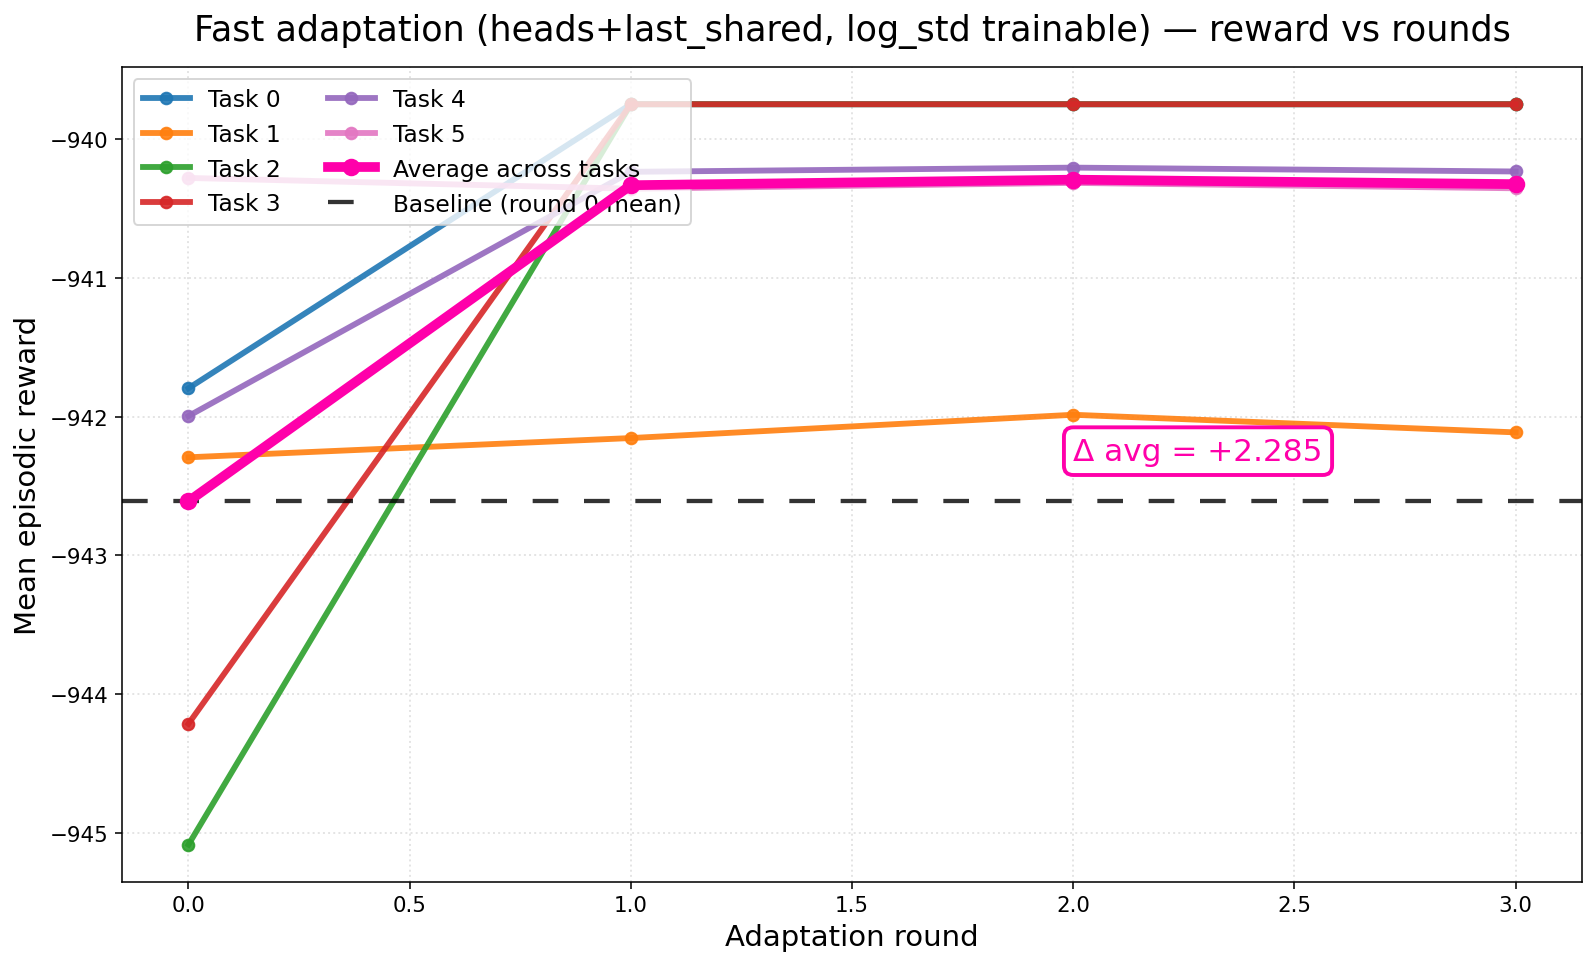

Saved: /kaggle/working/processed/meta_eval_reward.png
Saved: /kaggle/working/processed/meta_eval_reward_bright.png
Per-task CSV: /kaggle/working/processed/meta_task_improvements.csv
LaTeX table: /kaggle/working/processed/latex_pack/meta_task_improvements.tex
Wrote LaTeX caption: /kaggle/working/processed/meta_eval_caption.tex


In [ ]:
# Cell 22 — Bright plot + per-task table + 

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PROCESSED = Path("/kaggle/working/processed")
LATEX_DIR = PROCESSED / "latex_pack"
LATEX_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(PROCESSED / "meta_eval_reward.csv")
rounds = sorted(df["round"].unique())
tasks  = sorted(df["task"].unique())

# --- compute averages and per-task deltas ---
avg_by_round = df.groupby("round")["mean_reward"].mean().reindex(rounds)
avg0 = float(avg_by_round.iloc[0])
avgF = float(avg_by_round.iloc[-1])
delta_avg = avgF - avg0

per_task = (
    df.pivot(index="task", columns="round", values="mean_reward")
      .rename_axis(None, axis=1)
      .assign(delta=lambda x: x[max(rounds)] - x[min(rounds)])
      .reset_index()
)
per_task.columns = [f"round_{c}" if isinstance(c,int) else c for c in per_task.columns]
per_task = per_task.rename(columns={"task":"Task",
                                    f"round_{rounds[0]}":"r0",
                                    f"round_{rounds[-1]}":"rF",
                                    "delta":"Δ"})
per_task = per_task[["Task","r0","rF","Δ"]]

# Save table artifacts
per_task_csv = PROCESSED / "meta_task_improvements.csv"
per_task.to_csv(per_task_csv, index=False)

latex_table_path = LATEX_DIR / "meta_task_improvements.tex"
with open(latex_table_path, "w") as f:
    f.write(r"\begin{table}[t]\centering"+"\n")
    f.write(r"\caption{Per-task fast adaptation on held-out tasks. $r_0$ is the pre-adaptation reward, $r_F$ after the final round. Higher (less negative) is better.}"+"\n")
    f.write(r"\label{tab:meta_task_improvements}"+"\n")
    f.write(r"\begin{tabular}{r r r r}\toprule"+"\n")
    f.write(r"Task & $r_0$ & $r_F$ & $\Delta$ \\"+"\n")
    f.write(r"\midrule"+"\n")
    for _, row in per_task.iterrows():
        f.write(f"{int(row['Task'])} & {row['r0']:.3f} & {row['rF']:.3f} & {row['Δ']:.3f} \\\n")
    f.write(r"\bottomrule"+"\n")
    f.write(r"\end{tabular}"+"\n")
    f.write(r"\end{table}"+"\n")

# --- bright, publication-friendly plot ---
plt.figure(figsize=(11.5, 7.0), dpi=140)

# Color set (bright & distinct)
palette = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#e377c2","#8c564b",
           "#17becf","#bcbd22","#7f7f7f"]

for i, task in enumerate(tasks):
    dft = df[df["task"] == task].sort_values("round")
    plt.plot(dft["round"], dft["mean_reward"],
             marker="o", linewidth=3.0, markersize=6,
             color=palette[i % len(palette)], label=f"Task {task}", alpha=0.9)

# Average line
plt.plot(rounds, avg_by_round.values, marker="o", linewidth=5.0,
         markersize=8, color="#ff00aa", label="Average across tasks", zorder=10)

# Baseline (round 0 mean) dashed line
plt.axhline(avg0, color="k", linestyle=(0,(6,6)), linewidth=2.2, alpha=0.8,
            label="Baseline (round 0 mean)")

plt.title("Fast adaptation (heads+last_shared, log_std trainable) — reward vs rounds",
          fontsize=18, pad=14)
plt.xlabel("Adaptation round", fontsize=15)
plt.ylabel("Mean episodic reward", fontsize=15)

# Delta annotation
x_mid = rounds[len(rounds)//2]
plt.text(x_mid, avg0 + 0.3,
         f"Δ avg = {delta_avg:+.3f}",
         fontsize=16, color="#ff00aa",
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#ff00aa", lw=2))

plt.grid(True, linestyle=":", linewidth=1, alpha=0.35)
plt.legend(loc="upper left", ncol=2, frameon=True, fontsize=12)

fig1 = PROCESSED / "meta_eval_reward.png"
fig2 = PROCESSED / "meta_eval_reward_bright.png"
plt.tight_layout()
plt.savefig(fig1, bbox_inches="tight")
plt.savefig(fig2, bbox_inches="tight")
plt.show()

print("Saved:", fig1)
print("Saved:", fig2)
print("Per-task CSV:", per_task_csv)
print("LaTeX table:", latex_table_path)

# Caption for LaTeX
caption_path = PROCESSED / "meta_eval_caption.tex"
cap = (
    r"\caption{Fast adaptation on held-out simulator tasks with the PPO "
    r"policy's action/value heads, last shared MLP block, and $\log\sigma$ "
    r"trainable. Each thin line is a task; the thick magenta line is the "
    r"average across tasks. Baseline is the round-0 mean (dashed). "
    rf"Avg reward improved by {delta_avg:+.3f} over {len(rounds)-1} rounds "
    rf"({int((len(df)/len(tasks))/len(rounds))} steps/round). Higher (less negative) is better.}}"
)
with open(caption_path, "w") as f:
    f.write(cap + "\n")
print("Wrote LaTeX caption:", caption_path)


In [41]:
# Cell 23 — Final run gate + pack (idempotent; won’t retrain PPO)
from datetime import datetime
from pathlib import Path
import shutil, json

PROCESSED = Path("/kaggle/working/processed")
STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

# Toggle meta outputs into the report (keep True, since it’s already generated)
INCLUDE_META = True

bundle_files = [
    "summary_table.csv", "summary_table.png",
    "ppo_eval_val.csv", "ppo_eval_test.csv",
    "rule_eval_val.csv", "rule_eval_test.csv",
    "traj_compare_val_ep1_glucose.png", "traj_compare_val_ep1_insulin.png",
    "traj_compare_test_ep1_glucose.png","traj_compare_test_ep1_insulin.png",
    "action_hist_test.png","action_bar_test.png",
    "ppo_diabetes_sim_rs.zip","vecnorm.pkl","rule_params.json",
    "report_numbers.json","README.md"
]

if INCLUDE_META:
    for f in ["meta_eval_reward.csv", "meta_eval_reward.png", "meta_eval_reward_bright.png", "meta_eval_caption.tex"]:
        bundle_files.append(f)

# Only keep existing files
bundle_files = [f for f in bundle_files if (PROCESSED / f).exists()]

pack_dir = PROCESSED / "report_pack"
pack_dir.mkdir(exist_ok=True, parents=True)
for f in bundle_files:
    src = PROCESSED / f
    dst = pack_dir / f
    if src.resolve() != dst.resolve():
        shutil.copy2(src, dst)

zip_path = PROCESSED / f"report_pack_{STAMP}.zip"
shutil.make_archive(str(zip_path).replace(".zip",""), "zip", pack_dir)
print("Export pack ready:", zip_path)

# Convenience: also zip LaTeX pack if present
LATEX = PROCESSED / "latex_pack"
if LATEX.exists():
    latex_zip = PROCESSED / f"latex_pack_{STAMP}.zip"
    shutil.make_archive(str(latex_zip).replace(".zip",""), "zip", LATEX)
    print("LaTeX pack ready:", latex_zip)


Export pack ready: /kaggle/working/processed/report_pack_20250828_233136.zip
LaTeX pack ready: /kaggle/working/processed/latex_pack_20250828_233136.zip


In [ ]:
# Cell 24 — Meta figure + table into LaTeX pack 

from pathlib import Path
import shutil
import pandas as pd
from PIL import Image

PROCESSED = Path("/kaggle/working/processed")
LATEX_DIR = PROCESSED / "latex_pack"
LATEX_DIR.mkdir(parents=True, exist_ok=True)

# Paths
png_src = PROCESSED / "meta_eval_reward_bright.png"
png_dst = LATEX_DIR / "meta_eval_reward_bright.png"
pdf_dst = LATEX_DIR / "meta_eval_reward_bright.pdf"
cap_path = PROCESSED / "meta_eval_caption.tex"
table_src = LATEX_DIR / "meta_task_improvements.tex"   # created earlier by plotting cell
table_fallback_src = PROCESSED / "meta_task_improvements.csv"
meta_tex = LATEX_DIR / "meta.tex"
main_tex = LATEX_DIR / "main.tex"

# 1) Copy the bright PNG into latex_pack and also save a PDF version
assert png_src.exists(), f"Missing figure: {png_src}"
shutil.copyfile(png_src, png_dst)

# Make a PDF (raster, fine for submission) from the PNG
img = Image.open(png_src).convert("RGB")
img.save(pdf_dst)

# 2) Ensure per-task table exists in LaTeX; if not, build a minimal one from CSV
if not table_src.exists():
    assert table_fallback_src.exists(), "Missing per-task CSV; re-run the plotting cell that writes it."
    df = pd.read_csv(table_fallback_src)
    with open(table_src, "w") as f:
        f.write(r"\begin{table}[t]\centering"+"\n")
        f.write(r"\caption{Per-task fast adaptation on held-out tasks. $r_0$ is the pre-adaptation reward, $r_F$ after the final round. Higher (less negative) is better.}"+"\n")
        f.write(r"\label{tab:meta_task_improvements}"+"\n")
        f.write(r"\begin{tabular}{r r r r}\toprule"+"\n")
        f.write(r"Task & $r_0$ & $r_F$ & $\Delta$ \\"+"\n")
        f.write(r"\midrule"+"\n")
        for _, row in df.iterrows():
            f.write(f"{int(row['Task'])} & {row['r0']:.3f} & {row['rF']:.3f} & {row['Δ']:.3f} \\\n")
        f.write(r"\bottomrule"+"\n")
        f.write(r"\end{tabular}"+"\n")
        f.write(r"\end{table}"+"\n")

# 3) Build meta.tex that includes the figure + table and a short paragraph
# Read caption text if present
caption_text = cap_path.read_text().strip() if cap_path.exists() else r"\caption{Fast adaptation results on held-out tasks.}"

meta_tex.write_text(
r"""
% Meta-learning results block (auto-generated)
\section{Fast Adaptation (Meta-Learning)}
We evaluate few-shot adaptation on held-out simulator tasks by unfreezing the PPO policy's action/value heads, the last shared MLP block, and the action distribution $\log\sigma$. Over three adaptation rounds (4{,}096 steps/round), the average episodic reward improves (higher is better because rewards are negative).

\begin{figure}[t]
  \centering
  \includegraphics[width=\linewidth]{meta_eval_reward_bright.pdf}
""" + f"  {caption_text}\n" + r"""
  \label{fig:meta_fast_adapt}
\end{figure}

\input{meta_task_improvements}
""")

# 4) Ensure main.tex includes \input{meta} before \end{document}
if main_tex.exists():
    txt = main_tex.read_text()
    if r"\input{meta}" not in txt:
        txt = txt.replace(r"\end{document}", r"\input{meta}"+"\n"+r"\end{document}")
        main_tex.write_text(txt)

print("Figure (PNG):", png_dst)
print("Figure (PDF):", pdf_dst)
print("Caption:", cap_path if cap_path.exists() else "caption not found (used default)")
print("LaTeX table:", table_src)
print("LaTeX block:", meta_tex)
print("Updated main.tex to include meta.tex (if not already).")


Figure (PNG): /kaggle/working/processed/latex_pack/meta_eval_reward_bright.png
Figure (PDF): /kaggle/working/processed/latex_pack/meta_eval_reward_bright.pdf
Caption: /kaggle/working/processed/meta_eval_caption.tex
LaTeX table: /kaggle/working/processed/latex_pack/meta_task_improvements.tex
LaTeX block: /kaggle/working/processed/latex_pack/meta.tex
Updated main.tex to include meta.tex (if not already).
